# Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    PolynomialFeatures, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    KBinsDiscretizer
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge, 
    Lasso
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)   
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    recall_score,
    precision_score
)


from scripts.clean_dataset import clean_dataset
from scripts.helper import currency, cal_accuracy


# Importing the cleaned dataset

In [65]:
df_train = pd.read_csv('data/Train_cleaned.csv')
#df_train = pd.read_csv('data/Train_cleaned_log_transformed.csv')
#df_test  = pd.read_csv('data/Test.csv')
#df_test  = clean_dataset(df_test)

In [31]:
df_train.shape

(2789, 27)

not used yet:

In [66]:
# List of columns to one-hot encode
one_hot_columns = ['country', 'travel_with', 'purpose', 'main_activity', 'info_source', 
                   'tour_arrangement', 'payment_mode', 'most_impressing']

# List of columns to label encode
label_columns = ['age_group']

# Perform one-hot encoding
df_one_hot = pd.get_dummies(df_train[one_hot_columns], drop_first=True)

# Perform label encoding
label_encoder = LabelEncoder()
df_label = df_train[label_columns].apply(label_encoder.fit_transform)

## Categorization of total_cost (manually)

In [ ]:
#bin_edges  = [0, 500, 1500, 5000, float('inf')]
#bin_labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column 'cost_category' based on the binning
#df_train['total_cost_category'] = pd.cut(
#    df_train['total_cost_euro'], 
#    bins=bin_edges, 
#    labels=bin_labels, 
#    right=False,
#    include_lowest=True,
#)

## Categorization of total_cost (using KBins)

In [67]:
kbins = KBinsDiscretizer(
    n_bins=5,
    encode='onehot-dense', # onehot, onehoe-dense, ordinal
    strategy='quantile',   # kmeans, uniform, quantile
)
bin_data  = kbins.fit_transform(df_train[['total_cost_euro']])
bin_names = ['very low', 'low', 'medium', 'high', 'very high']
bin_edges = kbins.bin_edges_[0].round()

# Apply pd.cut with custom bin edges to start the first bin at zero
bin_edges = np.concatenate(([0], bin_edges[1:]))

df_train['total_cost_category'] = pd.cut(
    df_train['total_cost_euro'], 
    bins=bin_edges, 
    labels=bin_names, 
    include_lowest=True,
    right=False
)

In [68]:
# show the bins
for i in range(len(bin_names)):
    print(bin_names[i].ljust(10), f"{currency(bin_edges[i])} - {currency(bin_edges[i+1])}".center(30))

very low         0.00 € - 208.00 €       
low             208.00 € - 708.00 €      
medium         708.00 € - 1,976.00 €     
high          1,976.00 € - 4,537.00 €    
very high     4,537.00 € - 36,330.00 €   


# Target and Features

In [69]:
# Target:
y = df_train['total_cost_category']
#y = df_train['total_cost']
# Features:
X = df_train.drop([
    'total_cost', 'total_cost_euro', 'total_cost_category', 
], axis=1)

## Seperate numerical and categorical features

In [93]:
num_features = list(X.select_dtypes(include=['number']).columns)
cat_features = list(X.select_dtypes(exclude=['number']).columns)

In [8]:
#cat_features = list(set(cat_features) - set(['info_source', 'payment_mode', 'most_impressing']))
#num_features = ['total_travelers', 'night_total', 'total_female']

In [94]:
#num_features = ['total_travelers', 'night_total', 'total_female']
#cat_features = ['country', 'age_group', 'travel_with', 'main_activity', 'tour_arrangement', 'purpose']

cat_features, num_features

(['country',
  'age_group',
  'travel_with',
  'purpose',
  'main_activity',
  'info_source',
  'tour_arrangement',
  'package_transport_int',
  'package_accomodation',
  'package_food',
  'package_transport_tz',
  'package_sightseeing',
  'package_guided_tour',
  'package_insurance',
  'payment_mode',
  'first_trip_tz',
  'most_impressing',
  'single_female',
  'single_male'],
 ['total_female',
  'total_male',
  'night_mainland',
  'night_zanzibar',
  'total_travelers',
  'night_total'])

# Splitting the dataset

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)#, stratify=y)#, random_state=47)

# Baseline Model

Our baseline model is just using the median of all spendings.

In [96]:
print('Mean:  ', currency(df_train.total_cost_euro.mean()))
print('Median:', currency(df_train.total_cost_euro.median()))

Mean:   2,958.33 €
Median: 1,209.97 €


In [97]:
df_train.total_cost_euro.describe().apply(lambda x: currency(x))

count     3,099.00 €
mean      2,958.33 €
std       4,396.78 €
min          17.88 €
25%         302.49 €
50%       1,209.97 €
75%       3,629.92 €
max      36,329.50 €
Name: total_cost_euro, dtype: object

# Create a pipeline

## Building the pipeline

In [132]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
#    ('poly',    PolynomialFeatures(degree=10))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

# Create a Logistic Regression pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
#   ('classifier',   LogisticRegression(max_iter=10_000, class_weight="balanced"))
    ('classifier',   RandomForestClassifier(max_depth=5, n_estimators=50, min_samples_split=10))
#    ('classifier',   RandomForestRegressor())
#    ('classifier', Ridge(alpha=0.5)),
#    ('classifier', DecisionTreeClassifier(min_samples_leaf=))
#    ('classifier', GradientBoostingClassifier(n_estimators=100))
])

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_female', 'total_male',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'total_travelers',
                                                   'night_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder...
                                                   'info_source',
                                                   'tour_arrangement',
                                                   'package_transport_int',
                                                   'package_accomodation',
                                                   'package_food',
                                                   'package_transport_tz',
                                                   'package_sightseeing',
                                                   'package_guided_tour',
                                                   'package_insurance',
                                                   'payment_mode',
                                                   'first_trip_tz',
                                                   'most_impressing',
                                                   'single_female',
                                                   'single_male'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=10,
                                        n_estimators=50))])

## Predicting

In [133]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)

## Evaluation

### Training set evaluation

Accuracy on train set: 0.55
Accuracy on train set: 0.55
              precision    recall  f1-score   support

        high       0.65      0.42      0.51       431
         low       0.45      0.29      0.35       421
      medium       0.51      0.41      0.45       435
   very high       0.58      0.85      0.69       446
    very low       0.54      0.76      0.63       436

    accuracy                           0.55      2169
   macro avg       0.54      0.55      0.53      2169
weighted avg       0.55      0.55      0.53      2169



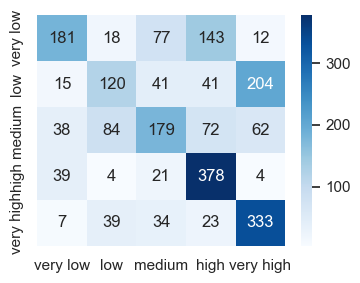

In [134]:
print("Accuracy on train set:", round(estimator.score(X_train, y_train), 2))
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))

print(classification_report(y_train, y_pred_train))

cf_train = confusion_matrix(y_train, y_pred_train)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_train, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

### Test set evaluation

Accuracy on test set: 0.48
Accuracy on test set: 0.48
              precision    recall  f1-score   support

        high       0.47      0.28      0.35       187
         low       0.43      0.26      0.32       203
      medium       0.46      0.36      0.41       182
   very high       0.52      0.81      0.63       176
    very low       0.50      0.75      0.60       182

    accuracy                           0.48       930
   macro avg       0.47      0.49      0.46       930
weighted avg       0.47      0.48      0.46       930



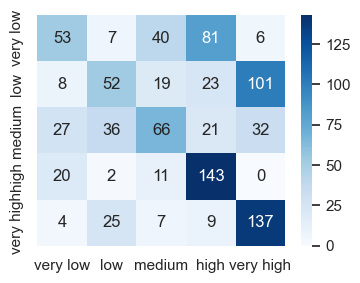

In [135]:
print("Accuracy on test set:", round(estimator.score(X_test,  y_test), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))

print(classification_report(y_test, y_pred_test))

cf_test = confusion_matrix(y_test, y_pred_test)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_test, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

In [ ]:
# The evaluation metric for this competition is Mean Absolute Error.

#mean_absolute_error(y_train, y_pred_train)

## Cross Validation

In [ ]:
y_pred_test_cv = cross_val_predict(estimator, X_test, y_test, cv=4)

In [ ]:
cv_score = estimator.score(X_test, y_pred_test_cv)
print("Cross validation scores:", round(cv_score, 2))
print(classification_report(y_test, y_pred_test_cv))

# Saving the model

In [82]:
from scripts.model_serializer import ModelSerializer

savegame = ModelSerializer('models/best_model.sav')
savegame.dump(estimator)

# Loading the model

In [83]:
savegame = ModelSerializer('models/best_model.sav')
model = savegame.load()
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=10))]),
                                                  ['total_female', 'total_male',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'total_travelers',
                                                   'night_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'age_group',
                                                   'travel_with', 'purpose',
                                                   'main_activity',
                                                   'info_source',
                                                   'tour_arrangement',
                                                   'payment_mode',
                                                   'most_impressing'])])),
                ('classifier', DecisionTreeClassifier())])

# Using "Test.csv"

In [84]:
reat_test_dataset = pd.read_csv('data/Test.csv')

In [85]:
ids = reat_test_dataset['ID']

real_test = clean_dataset(reat_test_dataset)

model = ModelSerializer('models/best_model.sav').load()
real_predictions =  pd.Series(model.predict(real_test), name='Predictions')

# Concatenate the Series and ndarray into a DataFrame
result_df = pd.concat([ids, real_predictions], axis=1)
result_df.columns = ['ids', 'predictions']
print(result_df.isna().sum())
result_df


ids             0
predictions    27
dtype: int64


,ids,predictions
0,tour_1,low
1,tour_100,medium
2,tour_1001,high
3,tour_1006,low
4,tour_1009,very high
...,...,...
1596,tour_988,NaN
1597,tour_990,NaN
1598,tour_992,NaN
1599,tour_996,NaN


# Grid Search

In [ ]:



# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'classifier': [
#        LogisticRegression(max_iter=10_000),
#        Ridge(alpha=0.5),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
#        XGBRegressor(),
    ],
}

# Create GridSearchCV,
grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error', #'r2', 
    verbose=1
)

# Fit the model
%timeit grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10))
    
error_analysis(y_test, y_pred_test)

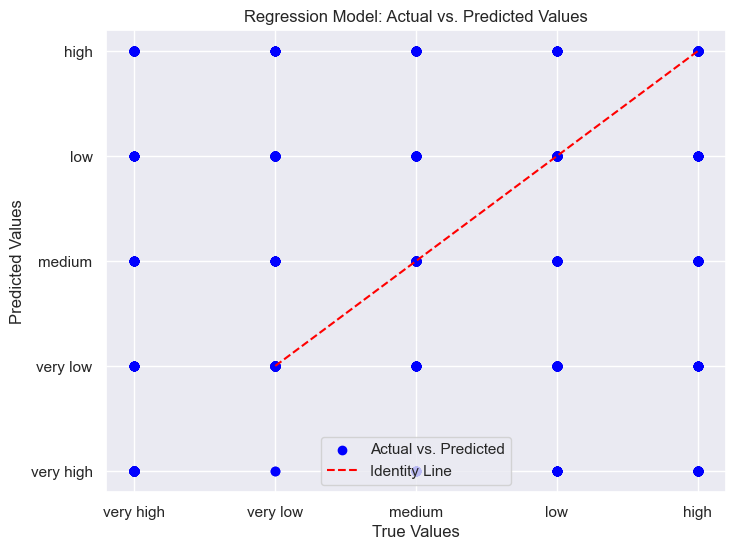

In [86]:

# Plotting the results
plt.figure(figsize=(8, 6))

# Scatter plot of true vs. predicted values
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs. Predicted')

# Plot the identity line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Identity Line')

plt.title('Regression Model: Actual vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()